#### <strong>第三次作品：三個分類器於兩組影像的評比實驗( Yale Face )</strong>
學號：711333104

姓名：林子齊
<hr>

 <font color=skyblue>作品目標</font>：本作品旨在比較不同分類器在原始資料與降維後（主成分資料）下的分類效能差異，並觀察資料型態轉換對模型表現的影響。

透過 Logistic Regression、SVM（含不同 kernel）、以及 MLP 等模型，分別對原始與 PCA 處理後的資料進行訓練與測試，評估各模型在不同情境下的準確率與穩定性。

最終目標為找出在不同資料條件下最具效能與穩定性的分類模型，並提供適用於高維特徵資料的模型選擇建議。
 <hr>

In [31]:
import numpy as np
import scipy.io
import pandas as pd
from HW3_common_utils import split_and_scale, apply_pca, run_logistic_regression_cv, run_logistic_gridcv, \
    run_svm_classification, run_mlp_classifier, plot_mlp_loss_curve, plot_mlp_confusion_matrix

先觀察資料的型態。


In [6]:
D = scipy.io.loadmat('data/allFaces.mat')
X = D['faces'] # 32256 x 2410 each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = D['m'].item() # 168
n = D['n'].item() # 192
n_persons = D['person'].item() # 38

# print the data information
print('X.shape =', X.shape)
print('y.shape =', y.shape)
print('Total number of images =', X.shape[1])
print('Total number of persons =', n_persons)
print('Image size =', m, 'x', n)
print('Number of images for each person =',y) 
print('Total number of images =', y.sum())

X.shape = (32256, 2410)
y.shape = (38,)
Total number of images = 2410
Total number of persons = 38
Image size = 168 x 192
Number of images for each person = [64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64]
Total number of images = 2410


由於 `y` 尚未包含對應的編號，因此需手動為每個人加上標籤，並透過列印前幾筆結果來確認標記是否正確。

In [7]:
# 根據 y 產生 0~37 的 label
label_list = []
for person_id, count in enumerate(y):  # y 是每人的圖片數
    label_list.extend([person_id] * count)
y_full = np.array(label_list)  # 長度為 2410

unique, counts = np.unique(y_full, return_counts=True)
print("前五位的圖片數量：")
for label, count in list(zip(unique, counts))[:5]:
    print(f"Person {label:2d}: {count} images")


前五位的圖片數量：
Person  0: 64 images
Person  1: 62 images
Person  2: 64 images
Person  3: 64 images
Person  4: 62 images


### 資料切分說明

為了進行交叉驗證時能減少資料偏差，我們將**資料依照原始類別比例**進行切分，將資料集分成：

- **訓練集（Training Set）**：70%
- **測試集（Testing Set）**：30%

透過**分層切分（stratified split）**，確保每一類別在訓練集與測試集中都保有相近的比例，有助於：

- 提高交叉驗證的代表性
- 降低模型偏誤（bias）
- 評估模型在未見資料上的泛化能力

In [8]:
X = X.T # 2410 x 32256 each row represents an image

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(
    X, y_full, test_size=0.3
)

print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")
print("類別數量：", len(np.unique(y_full)))

Training samples: 1687
Testing samples: 723
Training data shape: (1687, 32256)
Testing data shape: (723, 32256)
類別數量： 38


## 1. 原始資料

### 1-1 多元羅吉斯回歸 (Multinomial Logistic Regression)

使用帶有 5-fold 交叉驗證的多元邏輯斯回歸模型，採用 `lbfgs` 求解器，並搜尋 20 組對數尺度的 C 值進行正則化強度調整。

In [ ]:
# 執行 Logistic Regression CV
result = run_logistic_regression_cv(
    X_train_scaled, X_test_scaled, y_train, y_test,
    solver='lbfgs',
    Cs=np.logspace(-5, 5, 20),
    cv=5,
    tol=1e-6,
    max_iter=int(1e6),
    verbose=0,
    print_report=True
)

Logistic Regression with CV (solver = lbfgs)
Best C = [0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293]
Training Accuracy: 99.70%
Testing Accuracy : 96.96%
Elapsed time: 13854.20 seconds


模型選擇了相對較小的 C 值，顯示其偏好較強的正則化，有助於抑制過擬合。整體而言，模型在訓練與測試集上皆達到極高的準確率，展現出良好的學習能力與泛化效果。然而，訓練所需時間較長，顯示計算成本較高。

### 1-2 支援向量機

#### 1. 使用線性核（`kernel='linear'`）的 SVC 模型進行分類

In [28]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='linear',
    use_linear_svc=False 
)

SVM Classification (SVC-linear)
Test Accuracy: 92.67%
Elapsed Time: 178.09 seconds


模型在測試集上表現良好，準確率達到 92.67%，顯示具有不錯的分類效果。

#### 2. 使用線性核（`kernel='rbf'`）的 SVC 模型進行分類

In [36]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='rbf',
    C=0.1,
    gamma=0.2,
    use_linear_svc=False
)

SVM Classification (SVC-rbf)
Test Accuracy: 22.68%
Elapsed Time: 384.04 seconds


手動調整多組 `C` 與 `gamma` 參數後，模型的最佳測試準確率為 **22.68%**，整體表現很差。

#### 3. 使用線性核（`kernel='poly'`）的 SVC 模型進行分類
- degree=2

In [10]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='poly',
    degree=2,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 74.41%
Elapsed Time: 267.61 seconds


-  degree=3

In [11]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='poly',
    degree=3,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 65.84%
Elapsed Time: 273.09 seconds


使用多項式核（`kernel='poly'`）的 SVM 模型在本資料集上的表現不佳，且隨著多項式次數增加，模型效能明顯下降。當 **degree = 2** 時，測試準確率為 **74.41%**，而提高至 **degree = 3** 時，準確率驟降至 **65.84%**，顯示決策邊界可能過於複雜，導致**過擬合**或**泛化能力下降**。整體而言，本資料不適合採用高階多項式核函數進行建模。

In [ ]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test, tol=1e-4,
    use_linear_svc=True  
)

### 1-3 神經網路

#### 1. 使用一層隱藏層、50 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，Adam 作為優化器。

MLP Classifier Report
Test Accuracy: 91.29%
Elapsed Time: 48.33 seconds


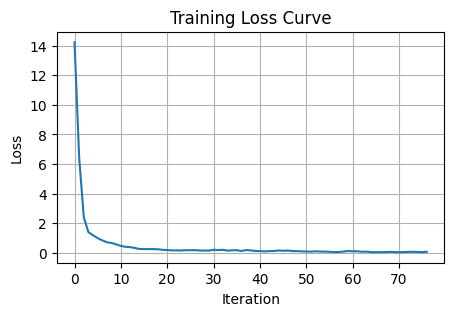

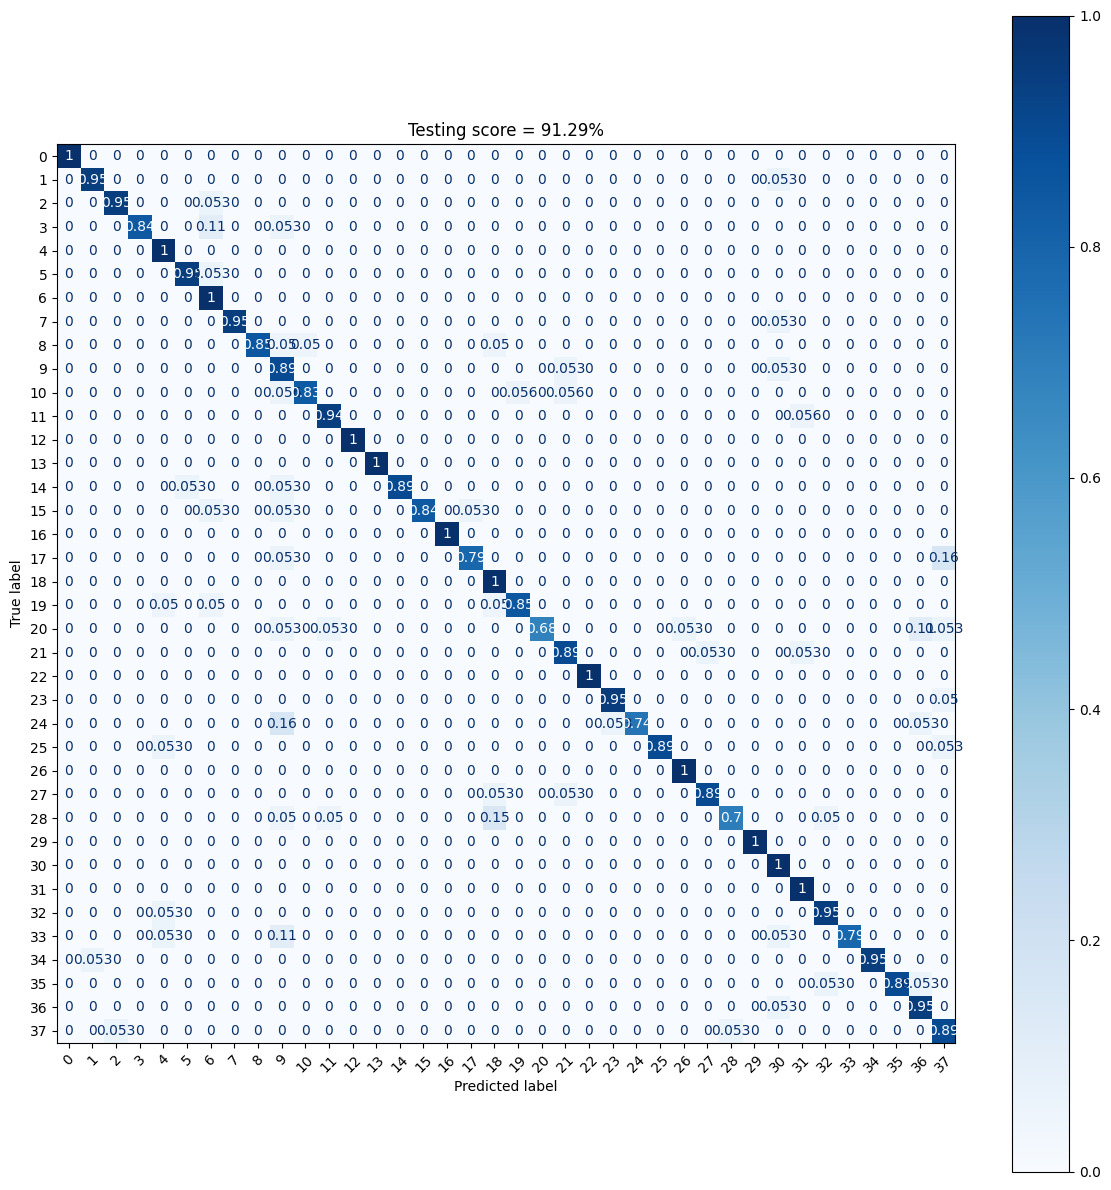

In [34]:
result = run_mlp_classifier(
    X_train_scaled, X_test_scaled, y_train, y_test,
    hidden_layers=(50),
    activation='relu',
    solver='adam',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_scaled, y_test)

**測試準確率（Test Accuracy）**：91.29%，模型分類效果良好。

從 Loss 曲線可以觀察到以下現象：

- 前期（前 10 次迭代）損失值快速下降，曲線在第 70 多次迭代後才逐漸趨於平穩，但整體訓練過程中仍可觀察到**輕微震盪與波動**，顯示模型在學習過程中存在些許不穩定性，可能與學習率、權重初始化或資料複雜度有關。

從混淆矩陣可以觀察到以下現象：
 
- 多數類別的預測集中於對角線，表示被正確分類的比例高。
- 少數格子出現錯誤分類，大部分錯誤的比例都在 **0.05 ~ 0.16**，表示整體誤分類風險仍屬可控範圍。

#### 2. 使用一層隱藏層、50 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，改採 sgd 作為優化器。

MLP Classifier Report
Test Accuracy: 94.74%
Elapsed Time: 132.17 seconds


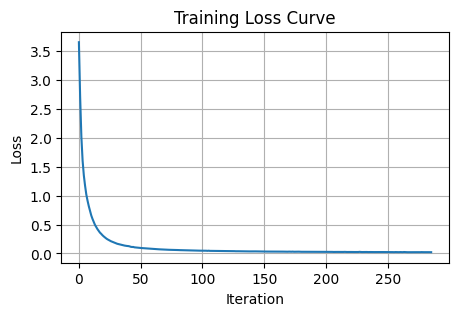

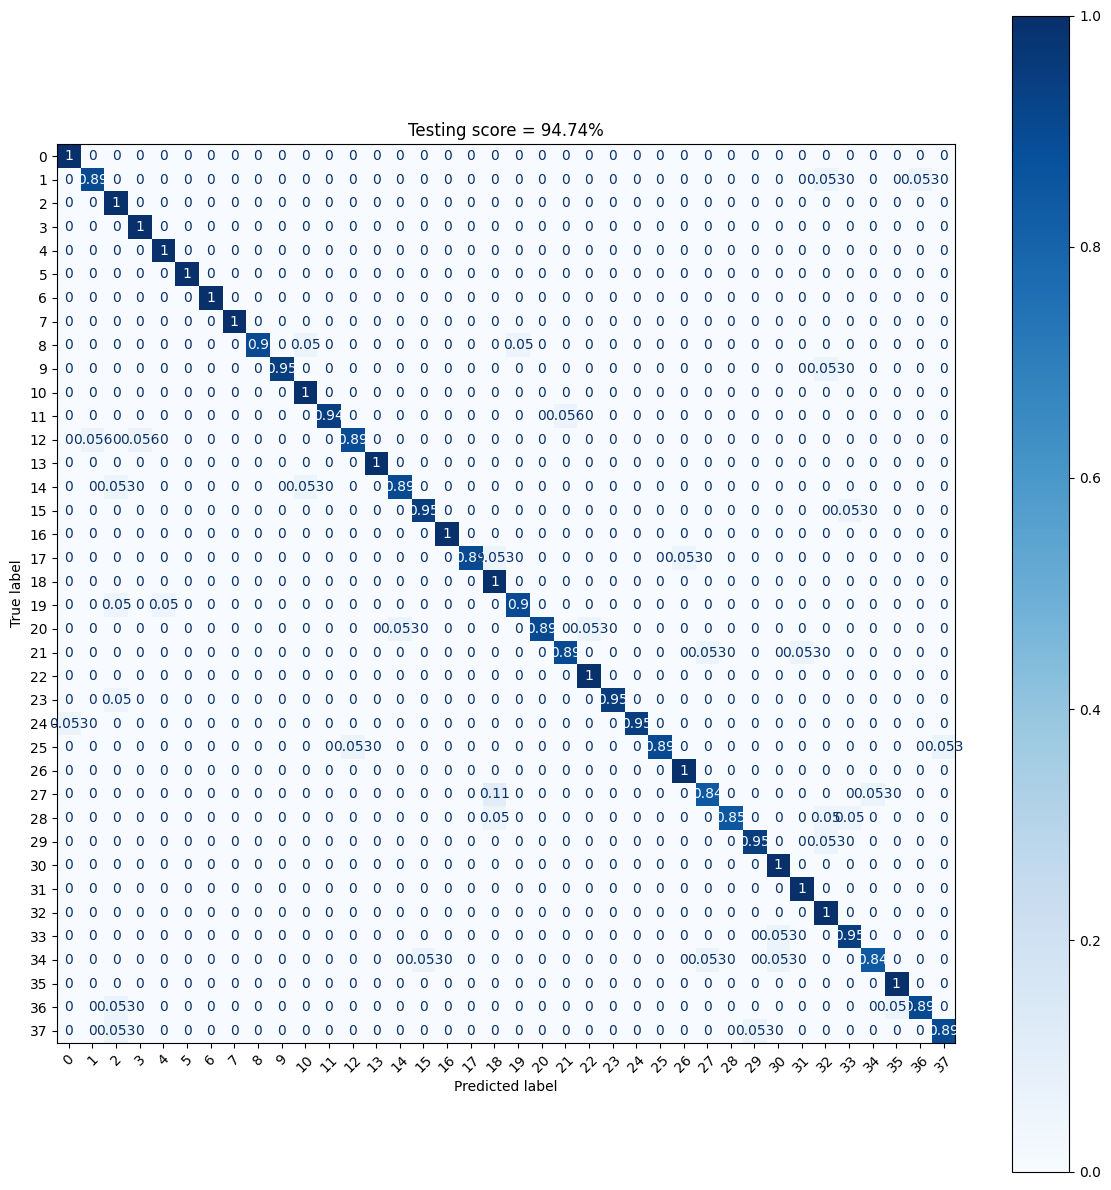

In [35]:
result = run_mlp_classifier(
    X_train_scaled, X_test_scaled, y_train, y_test,
    hidden_layers=(50,),
    activation='relu',
    solver='sgd',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_scaled, y_test)

**測試準確率（Test Accuracy）**：94.47%，模型分類效果良好。

從 Loss 曲線可以觀察到以下現象：
- 訓練初期損失值約為 3.6，模型能迅速學習，Loss 在前 25 次迭代內迅速下降。
- 此後 Loss 緩慢下降並持續收斂，在約第 250 次迭代時趨於穩定，整體曲線平滑，顯示模型學習過程穩定。
- 無明顯震盪或異常變化，表示訓練過程穩健。

從混淆矩陣可以觀察到以下現象：

- 多數類別的預測集中於對角線，表示被正確分類的比例高。
- 整體錯誤比例極低，分佈也較為分散，無明顯系統性偏誤。

## 2. 主成分資料

將原始標準化後的資料降維，保留 80% 的資料變異量（variance_ratio = 0.8）。

In [ ]:
X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, variance_ratio=0.8)

### 2-1 多元羅吉斯回歸 

In [ ]:
result = run_logistic_regression_cv(
    X_train_pca, X_test_pca, y_train, y_test,
    solver='lbfgs',
    Cs=np.logspace(-5, 5, 20),
    cv=5,
    tol=1e-6,
    max_iter=int(1e6),
    verbose=0,
    print_report=True
)

Logistic Regression with CV (solver = lbfgs)
Best C = [0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948 0.54555948
 0.54555948 0.54555948]
Training Accuracy: 37.40%
Testing Accuracy : 33.47%
Elapsed time: 181.96 seconds


觀察結果發現模型訓練效果非常差。為改善模型表現，後續將 `variance_ratio` 提高至 **0.95**，保留更多特徵資訊，以提升模型的學習與預測能力。

In [9]:
X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, variance_ratio=0.95)

In [21]:
result = run_logistic_regression_cv(
    X_train_pca, X_test_pca, y_train, y_test,
    solver='lbfgs',
    Cs=np.logspace(-5, 5, 20),
    cv=5,
    tol=1e-4,
    max_iter=int(1e6),
    verbose=0,
    print_report=True
)

Logistic Regression with CV (solver = lbfgs)
Best C = [0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293 0.0483293
 0.0483293 0.0483293 0.0483293]
Training Accuracy: 99.70%
Testing Accuracy : 95.71%
Elapsed time: 37.99 seconds


提升 `variance_ratio` 後，保留更多原始特徵資訊，使模型能更有效學習資料分布。相較於原先訓練結果混亂、準確率低落的情況，此次訓練效果**明顯改善**，測試準確率提升至超過 95%，模型具備良好泛化能力。

In [6]:
param_grid = {
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'C': [0.1, 1, 10]
}

result = run_logistic_gridcv(X_train_pca, y_train, param_grid=param_grid, tol=1e-4)

{'C': 0.1, 'solver': 'lbfgs'}
0.9171597633136095
LogisticRegression(C=0.1, max_iter=1000000)
Elapsed time: 240.05 seconds


交叉驗證下的平均準確率約為 91.72%，顯示所選參數組合在訓練階段表現良好。

### 2-2 支援向量機

#### 1. 使用線性核（`kernel='linear'`）的 SVC 模型進行分類

In [7]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='linear',
    use_linear_svc=False 
)

SVM Classification (SVC-linear)
Test Accuracy: 91.56%
Elapsed Time: 0.19 seconds


模型在測試集上表現良好，準確率達到 91.56%，顯示線性決策邊界對此資料集具有良好分類能力。

#### 2. 使用線性核（`kernel='rbf'`）的 SVC 模型進行分類

In [9]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='rbf',
    C=0.01,
    gamma=0.1,
    use_linear_svc=False
)

SVM Classification (SVC-rbf)
Test Accuracy: 38.87%
Elapsed Time: 0.26 seconds


手動調整多組 `C` 與 `gamma` 參數後，模型的最佳測試準確率為 **38.87%**，整體表現非常差。

#### 3. 使用線性核（`kernel='poly'`）的 SVC 模型進行分類
- degree=2

In [47]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='poly',
    degree=2,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 85.89%
Elapsed Time: 0.24 seconds


-  degree=3

In [29]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='poly',
    degree=3,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 82.57%
Elapsed Time: 0.20 seconds


使用多項式核函數（`kernel='poly'`）的 SVM 模型在本資料集上的表現相對有限，且隨著多項式次數增加，模型效能略有下降。當 **degree = 2** 時，測試準確率為 **85.89%**，提升至 **degree = 3** 時則下降至 **82.57%**，顯示高階多項式核並未帶來效能提升，反映資料本身對複雜非線性邊界的需求較低。

#### 4. 使用 `LinearSVC`

In [30]:
X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, variance_ratio=0.95)
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    use_linear_svc=True  
)

SVM Classification (LinearSVC)
Test Accuracy: 93.22%
Elapsed Time: 4.91 seconds


使用 LinearSVC 進行分類，測試準確率為 **93.22%**，整體表現尚可。  

### 2-3 神經網路

#### 1. 使用一層隱藏層、140 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，Adam 作為優化器。

MLP Classifier Report
Test Accuracy: 91.84%
Elapsed Time: 1.17 seconds


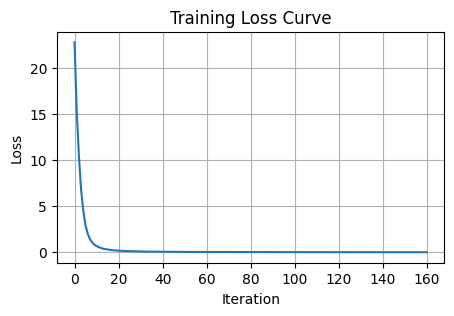

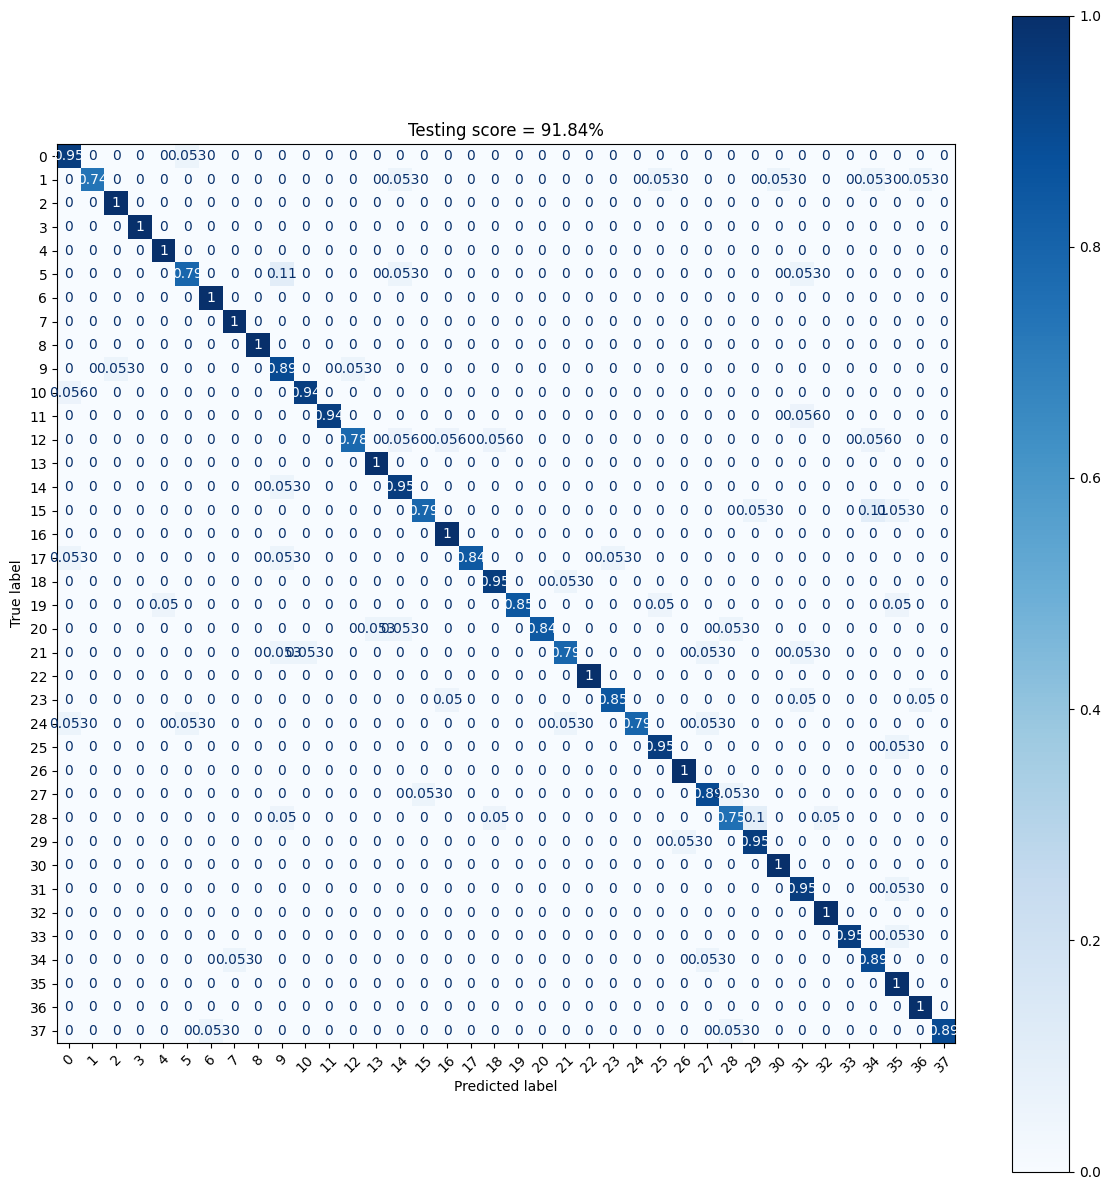

In [20]:
result = run_mlp_classifier(
    X_train_pca, X_test_pca, y_train, y_test,
    hidden_layers=(140,),
    activation='relu',
    solver='adam',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_pca, y_test)

**測試準確率（Test Accuracy）**：91.84%，模型分類效果良好。

從 Loss 曲線可以觀察到以下現象：
- 初始損失值超過 20，模型在約 30 次迭代內迅速將 loss 降至接近 0，之後逐漸趨於穩定，並於第 160 次左右完成收斂。
- 曲線平滑且無明顯震盪，顯示模型訓練過程穩定、有效。

從混淆矩陣可以觀察到以下現象：
- 多數類別的預測集中於對角線，表示被正確分類的比例高。
- 少數格子出現錯誤分類，大部分錯誤的比例都在 **0.05 ~ 0.11**，表示整體誤分類風險仍屬可控範圍。

#### 2. 使用一層隱藏層、300 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，改採 sgd 作為優化器。

MLP Classifier Report
Test Accuracy: 91.56%
Elapsed Time: 3.02 seconds


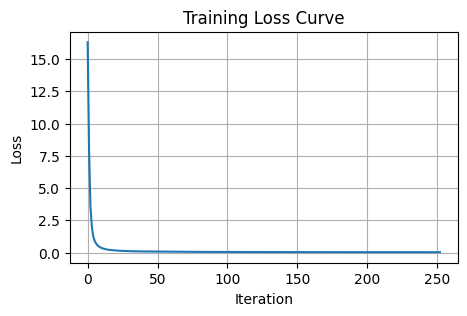

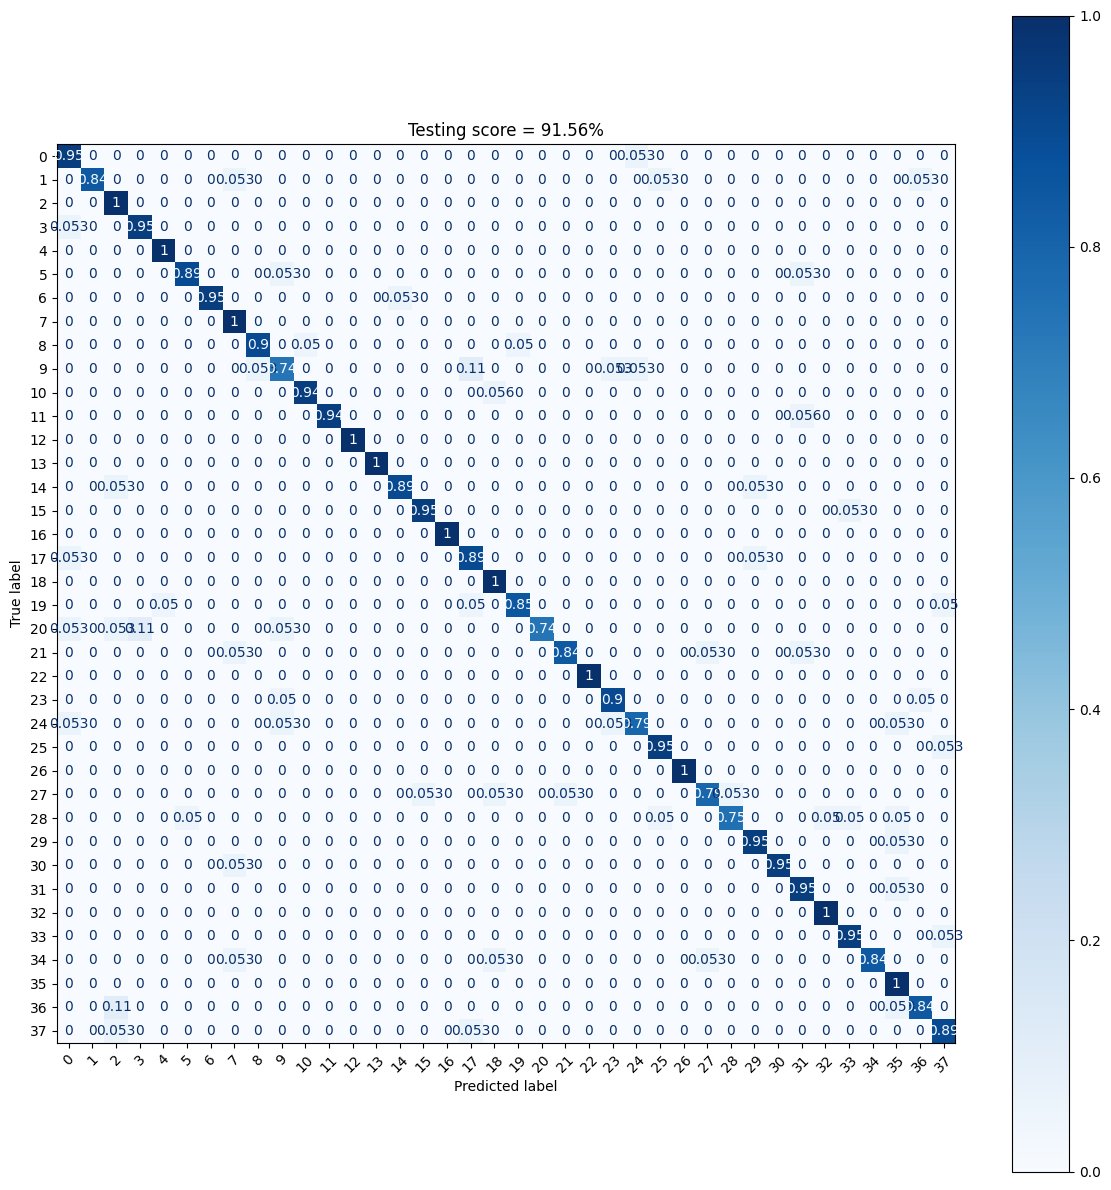

In [33]:
result = run_mlp_classifier(
    X_train_pca, X_test_pca, y_train, y_test,
    hidden_layers=(300,),
    activation='relu',
    solver='sgd',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_pca, y_test)

**測試準確率（Test Accuracy）**：91.56%，模型分類效果良好。

從 Loss 曲線可以觀察到以下現象：
- 初始損失值超過 15，前期損失值快速下降，之後逐漸趨於穩定，並於第 250 次左右完成收斂。
- 曲線平滑、無明顯震盪，表示模型訓練過程穩定、有效收斂。

從混淆矩陣可以觀察到以下現象：
- 多數類別的預測集中於對角線，表示被正確分類的比例高。
- 少數格子出現錯誤分類，大部分錯誤的比例都在 **0.05 ~ 0.11**，表示整體誤分類風險仍屬可控範圍。

## 第二份資料：分類器在原始資料與主成分資料下的效能比較

### 測試準確率比較表

| 分類器             | 原始資料 (%) | 主成分資料 (%) | 差異說明                           |
|--------------------|---------------|------------------|------------------------------------|
| Logistic Regression | **99.70**     | **99.70**        | 完全一致，模型穩定性極高             |
| SVM-linear         | 92.67         | 91.56            | 略降，仍屬高準確率                   |
| SVM-rbf            | 22.68         | **38.87**        | 皆偏低，主成分有幫助但仍表現不佳      |
| SVM-poly (deg=2)   | 74.41         | 85.89            | 明顯改善，PCA 幫助提升表現            |
| SVM-poly (deg=3)   | 65.84         | 82.57            | 大幅改善，可能減少過擬合              |
| LinearSVC          |               | **93.22**        |                   |
| MLP-adam           | 91.29         | 91.84            | 主成分略提升                        |
| MLP-sgd            | **94.74**     | 91.56            | PCA 後略降，但仍具良好表現            |

- 原始資料LinearSVC運算過久，所以沒納入。
---

### 討論與觀察重點

1. **表現最穩定者**為 Logistic Regression，兩種資料下準確率皆達 **99.70%**，顯示模型對特徵維度不敏感，極具穩定性。
2. **SVM-rbf 效能低落**，即使經 PCA 處理仍僅提升至 38.87%，不建議使用於此資料。
3. **SVM-poly 系列在 PCA 處理後準確率大幅上升**，顯示原始高維特徵可能導致模型過擬合，而降維有助穩定分類邊界。
4. **MLP 模型表現穩定且快速**，PCA 對其影響不大，適合追求平衡效率與準確率的場景。

---

### 小結建議

- 若追求高準確率與效率，建議使用 **Logistic Regression + 主成分資料。
- **SVM-rbf 不推薦使用**於此資料集，效果受限。
